In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#conda install pandas==0.25.1

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
def deleteindex(indexi, dataframe):
    for it in indexi:
        #print(it)
        dataframe = dataframe.drop(dataframe.index[it])   
    return dataframe

# Loading data

In [5]:
mood = pd.read_csv("mood_sampling_data.csv")
phone_use = pd.read_csv("phone_use_data.csv")
categories = pd.read_csv("app_categories.csv")

# Cleaning, Preprocessing, Feature Extraction

In [6]:
#remove duplicate rows in phone use and mood dataset
phoneuse_without_duplicates = phone_use.drop_duplicates() #dropped 19280 rows --> phoneuse_without_duplicates now has 567512 rows
mood_without_duplicates = mood.drop_duplicates() #dropped 14 rows --> mood_without_duplicates now has 16002 rows
#print(len(phone_use))
#print(len(phoneuse_without_duplicates))
#print(len(mood))
#print(len(mood_without_duplicates))

In [7]:
#remove expired, canceled and blocked sessions in mood data
mood_without_expired = mood_without_duplicates.drop(mood_without_duplicates[mood_without_duplicates["duration"] == "Expired"].index) #dropped 6282 rows --> mood_without_expired now has 9720 rows
mood_without_blocked = mood_without_expired.drop(mood_without_expired[mood_without_expired["duration"] == "Blocked"].index) #dropped 104 rows --> mood_without_blocked now has 9616 rows
mood_without_cancel = mood_without_blocked.drop(mood_without_blocked[mood_without_blocked["duration"] == "Canceled"].index) #dropped 12 rows --> mood_without_cancel now has 9604 rows
#print(len(mood_without_blocked))

In [8]:
#find the number of unique users in phone use data and mood data and delete the error id's
ids_phoneuse = ((pd.unique(phoneuse_without_duplicates["user_id"])))
ids_mood = ((pd.unique(mood_without_cancel["user_id"])))
difference_id = (np.setdiff1d(ids_mood, ids_phoneuse)) #there are 23 errornous user id's in the dataset
#print(len(difference_id))

mood_without_errorids = mood_without_cancel
#total=0

#find and delete the indexes of the error user_ids
for item in difference_id:
    #print(item)
    indexes = np.where(mood_without_errorids["user_id"] == item)
    #print(indexes)\n",
    #in total 1084 rows are connected to the 24 errornous user id's
    #total= total + (len(indexes[0]))
    #print(total)
    #print(len(indexes[0]))
    mood_without_errorids = deleteindex(indexes, mood_without_errorids) #dropped 1084 rows --> mood_without_errorids now has 8520 rows

In [9]:
#convert also energetic, cheerful and tired to float
#print(new_mood["energetic"])
mood_without_errorids["energetic"] = mood_without_errorids["energetic"].astype(float)
mood_without_errorids["cheerful"] = mood_without_errorids["cheerful"].astype(float)
mood_without_errorids["tired"] = mood_without_errorids["tired"].astype(float)

In [10]:
#convert sent_time of mood dataset to a datetime type and split date and time into new variables
mood_without_errorids["response_time"] = mood_without_errorids["response_time"].str.rstrip(" CET")
mood_without_errorids["response_time"] = pd.to_datetime(mood_without_errorids['response_time'])
mood_without_errorids['response_date'] = mood_without_errorids['response_time'].dt.date
mood_without_errorids['response_hours'] = mood_without_errorids['response_time'].dt.time
mood_without_errorids['response_date'] = pd.to_datetime(mood_without_errorids['response_date'])
#mood_without_nans['response_time']"

/Users/mariekeroost/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname CES identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [11]:
#there are 14 apps that do not have a category or name in the categories dataset, so the NaN categories are categorized based on the hybrid category and NaN names are based on category names
#print(categories.isnull().sum())
index_NaN_category = (np.where(categories["category"].isnull()))
for item in index_NaN_category:
    categories.ix[item, "category"] = categories.ix[item, "better_category_hybrid"]

index_NaN_category_name = (np.where(categories["name"].isnull()))
for itemn in index_NaN_category_name:
    categories.ix[itemn, "name"] = categories.ix[itemn, "category"]

/Users/mariekeroost/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
/Users/mariekeroost/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
/Users/mariekeroost/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

In [12]:
#change name application so merge can take place
phoneuse_without_duplicates = phoneuse_without_duplicates.rename(columns = {"application" : "app_id"})

#merge app categories together with phone use
phone_use_categories = pd.merge(phoneuse_without_duplicates, categories, how = "inner", on = "app_id") #new dataframe has now 457182 rows
#print(phone_use_categories.isnull().sum())

In [13]:
#time in registration endings is not the same for phone use data and mood data
#the last registration of a session in phone use is on 2019-03-26 15:50:47.045
#the last registration of a mood survey sent is 2019-05-14 10:01:53
#because last registration of phone use is on 26-03-2019 afternoon, all mood registrations tm 26-03 are included and all mood registrations afterwards are exluded

#detect the index of the dates after 26-03-2019
the_date = '2019-03-27'
indexes_dates = np.where(mood_without_errorids["response_date"] >= the_date) #138 rows are "overtime"
mood_without_time_outliers = deleteindex(indexes_dates, mood_without_errorids) #drops 138 rows --> mood_without_time_outliers now has 8390 rows

In [14]:
#Create new column with duration of application category in SECONDS in phone use data\n",
phoneuse_categories_back = phone_use_categories
phoneuse_categories_back["duration_app"] = (phoneuse_categories_back["endTimeMillis"] - phoneuse_categories_back["startTimeMillis"])/1000

In [15]:
#create new column with frequency used of application category in phone use data
phoneuse_categories_back["frequency_app"] = 1.0

In [16]:
#create a new column for the new categories
phoneuse_categories_back["new_category"] = " "

In [17]:
#add the new categories to the new_category column based on hybrid and normal category. 
#first the 7 most used apps (>10.000) get an own category
phoneuse_categories_back.new_category[phoneuse_categories_back.better_category_hybrid == "Facebook Messenger"] = "Facebook_Messenger"
phoneuse_categories_back.new_category[phoneuse_categories_back.better_category_hybrid == "Spotify"] = "Spotify"
phoneuse_categories_back.new_category[phoneuse_categories_back.better_category_hybrid == "WhatsApp Messenger"] = "Whatsapp_Messenger"
phoneuse_categories_back.new_category[phoneuse_categories_back.better_category_hybrid == "Instagram"] = "Instagram"
phoneuse_categories_back.new_category[phoneuse_categories_back.better_category_hybrid == "Snapchat"] = "Snapchat"
phoneuse_categories_back.new_category[phoneuse_categories_back.better_category_hybrid == "Facebook"] = "Facebook"
phoneuse_categories_back.new_category[phoneuse_categories_back.better_category_hybrid == "Google Chrome"] = "Google_Chrome"
phoneuse_categories_back.new_category[phoneuse_categories_back.better_category_hybrid == "YouTube"] = "Youtube"

#all other 'normal' categories are merged together in 10 new categories
#first the categories that exist partly out of the 7 most used apps
phoneuse_categories_back.new_category[(phoneuse_categories_back.category == "Video Players & Editors") & (phoneuse_categories_back.better_category_hybrid != "YouTube")] = "Entertainment"
phoneuse_categories_back.new_category[(phoneuse_categories_back.category == "Music & Audio") & (phoneuse_categories_back.better_category_hybrid != "Spotify")] = "Entertainment"
phoneuse_categories_back.new_category[(phoneuse_categories_back.category == "Social") & (phoneuse_categories_back.better_category_hybrid != "Instagram") & (phoneuse_categories_back.better_category_hybrid != "Snapchat") & (phoneuse_categories_back.better_category_hybrid != "Facebook")] = "Social"
phoneuse_categories_back.new_category[(phoneuse_categories_back.category == "Communication") & (phoneuse_categories_back.better_category_hybrid != "WhatsApp Messenger") & (phoneuse_categories_back.better_category_hybrid != "Google Chrome") & (phoneuse_categories_back.better_category_hybrid != "Facebook Messenger")] = "Communication"

#all the other categories are merged together
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Books & Reference"] = "Entertainment"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Photography"] = "Entertainment"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Entertainment"] = "Entertainment"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Art & Design"] = "Entertainment"

phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Finance"] = "Finance"

phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Adventure"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Racing, Action & Adventure"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Trivia"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Card"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Puzzle"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Board"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Racing"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Simulation"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Arcade"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Action"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Casino"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Casual"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Word"] = "Games"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Strategy"] = "Games"

phoneuse_categories_back.new_category[phoneuse_categories_back.category == "News & Magazines"] = "Lifestyle"#voornamelijk NOS of teletekst 
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Travel & Local"] = "Lifestyle"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Lifestyle"] = "Lifestyle"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Weather"] = "Lifestyle"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Dating"] = "Lifestyle"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Sports"] = "Lifestyle"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Health & Fitness"] = "Lifestyle"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "House & Home"] = "Lifestyle"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Education"] = "Lifestyle"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Medical"] = "Lifestyle"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Food & Drink"] = "Lifestyle"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Maps & Navigation"] = "Lifestyle"

phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Background Process"] = "Background_Process"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Security"] = "Background_Process"

phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Auto & Vehicles"] = "Online_Shopping"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Shopping"] = "Online_Shopping"

phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Productivity"] = "Productivity"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Personalization"] = "Productivity"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Document_Editor"] = "Productivity"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Business"] = "Productivity"

phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Tools"] = "Utility"
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Phone_Tools"] = "Utility"

#all the registrations that are in the normal 'other' category, is the same app, which is a news app. therefore other will get lifestyle category
phoneuse_categories_back.new_category[phoneuse_categories_back.category == "Others"] = "Lifestyle"


/Users/mariekeroost/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mariekeroost/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/mariekeroost/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

# Figures of cleaning and preprocessing part

Text(0, 0.5, 'Total frequency')

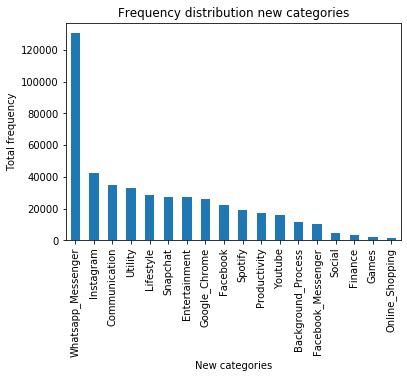

In [18]:
df = (phoneuse_categories_back["new_category"].value_counts())
ax = df.plot.bar(title = "Frequency distribution new categories")
ax.set_xlabel("New categories")
ax.set_ylabel("Total frequency")


Text(0, 0.5, 'Total frequency')

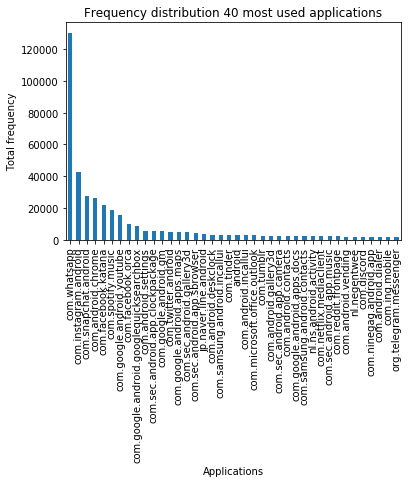

In [19]:
dff = (phoneuse_categories_back["app_id"].value_counts()[0:40])
axx = dff.plot.bar(title = "Frequency distribution 40 most used applications")
axx.set_xlabel("Applications")
axx.set_ylabel("Total frequency")


In [20]:
#clean up the mood dataset, so all columns that are not needed are deleted for better view
mood_cleaned = mood_without_time_outliers
del mood_cleaned["social_private"]
del mood_cleaned["social_public"]
del mood_cleaned["social_partener"]
del mood_cleaned["social_friend"]
del mood_cleaned["social_family"]
del mood_cleaned["social_coworkers"]
del mood_cleaned["duration"]
del mood_cleaned["day_time_window"]
del mood_cleaned["activities_work"]
del mood_cleaned["activities_social"]
del mood_cleaned["activities_sports"]
del mood_cleaned["activities_leisure"]
del mood_cleaned["activities_commute"]
del mood_cleaned["activities_sleep"]
del mood_cleaned["activities_chore"]
del mood_cleaned["inferior"]
del mood_cleaned["activity"]
del mood_cleaned["social"]
del mood_cleaned["enjoy"]
del mood_cleaned["activities_study"]
del mood_cleaned["activities_class"]
del mood_cleaned["response_time"]
del mood_cleaned["sent_time"]
del mood_cleaned["response_date"]
del mood_cleaned["response_hours"]

In [21]:
#clean up the phonse use dataset, so all columns that are not needed are deleted for better view
phone_use_cat_cleaned = phoneuse_categories_back
del phone_use_cat_cleaned["battery"]
del phone_use_cat_cleaned["notification"]
del phone_use_cat_cleaned["count"]
del phone_use_cat_cleaned["startTimeMillis"]
del phone_use_cat_cleaned["endTime"]
del phone_use_cat_cleaned["endTimeMillis"]
del phone_use_cat_cleaned["startTime"]
del phone_use_cat_cleaned["session"]
#del phone_use_cat_cleaned["end_date"]
#del phone_use_cat_cleaned["end_hours"]
del phone_use_cat_cleaned["better_category_hybrid"]
del phone_use_cat_cleaned["better_category"]


In [22]:
#save as new datasets
mood_cleaned.to_csv("cleaned_mood.csv")
phone_use_cat_cleaned.to_csv("cleaned_phoneuse_categories.csv")